In [1]:
import sys
import numpy as np
sys.path.insert(0, '..')

from unpast.utils.eval import generate_exprs
from unpast.utils.method import zscore


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Simulated expression data

* 10000 features x 200 samples
* background ~Norm(0,1), bicluster ~ Norm(4,1)
* four biclusters with fraction [0.05,0.1,0.25,0.5] of all columns (samples) simulate four subtypes

* Complexity:
    - Simple: n=500 features per bicluster 
    - Features: n=5 features per bicluster 
* Scenarios:
    - A: biclusters do not overlap
    - B: random overlaps in samples
    - C: random overlaps in samples + co-expression modules in the background
    
    
* co-expression modules of user-defined size with avg. Pearson r about 0.5 added to the background


In [2]:
# background expressions N(0,1)
seed = 42
# dimensions of the matrix
n_genes = 10000 # gemes 
N = 200  # samples

# bicluster expression parameters
m = 4
std = 1

# fractions of samples included to each subtype
frac_samples= [0.05, 0.1, 0.25, 0.5]

# number of biomarkers for each subtype
n_biomarkers = 500 # 5, 50, 500

# add 4 co-expression modules of 500 genes each, with avg. r=0.5 
add_coexpressed = [500]*4 


# Scenario C 
* overlapping sample clusters 
* four 500-feature co-expression modules added to the background
* ! only 2000 background genes are shown in the figure


C_500
	co-exprs. module 500 features, avg. pairwise r=0.46
	co-exprs. module 500 features, avg. pairwise r=0.55
	co-exprs. module 500 features, avg. pairwise r=0.50
	co-exprs. module 500 features, avg. pairwise r=0.49


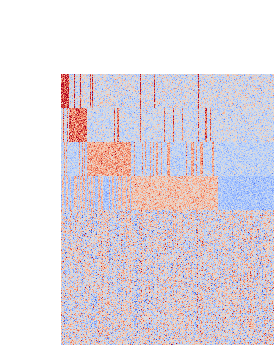

In [3]:
scenario = "C_"+str(n_biomarkers)
print(scenario)

# generate input data and ground truth
exprs, ground_truth, coexpressed_modules = generate_exprs((n_genes,N),
                                                         g_size=n_biomarkers,
                                                         frac_samples=frac_samples,
                                                         m=m,std=std,
                                                         #outdir = ,outfile_basename=, # specify to save data
                                                         g_overlap=False,s_overlap=True,
                                                         seed = seed, 
                                                         add_coexpressed = add_coexpressed
                                                         )





############ Plots ##################
def plot_heatmap(exprs = exprs, 
                 ground_truth = ground_truth, 
                 coexpressed_modules = [], # a list of co-expression modules if available
                 show_n_bg = 2000, # how many background feature to display in plots
                 fig_file = ""#"img/Fig3C.png" 
                ):
    bic_g = []
    bic_s = []
    for row in ground_truth.iterrows():
        bic = row[1]
        g = list(bic["genes"])
        s = list(bic["samples"])
        bic_g += g
        bic_s += s

    coexprs_g = set([])
    if coexpressed_modules:
        #for module in coexpressed_modules:
        #    bic_g +=  [x for x in module if not x in bic_g]
            
        for cm in coexpressed_modules:
            coexprs_g|= set(cm)

    bg_g = sorted(set(exprs.index.values).difference(set(bic_g)).difference(coexprs_g))
    bg_s = sorted(set(exprs.columns.values).difference(set(bic_s)))

    samples = bic_s + bg_s
    genes =  sorted(coexprs_g)+ bg_g
    genes = bic_g+genes[:show_n_bg]

    exprs = zscore(exprs)
    figC = sns.clustermap(zscore(exprs.loc[genes,samples]),
                        xticklabels=False,yticklabels=False,
                        row_cluster=False,col_cluster=False,
                        cmap=sns.color_palette("coolwarm", as_cmap=True),
                        vmin=-3,vmax=3,
                       figsize = (4,5))

    figC.ax_cbar.set_visible(False) # switch on/off colorbar
    if fig_file:
        figC.savefig(fig_file, transparent=True)
        
plot_heatmap(exprs = exprs, 
            ground_truth = ground_truth, 
            coexpressed_modules = coexpressed_modules, 
            fig_file = ""#"img/Fig3C.png" 
            )

In [4]:
!mkdir -p "../test_data/"
!mkdir -p "../test_data/unpast_results/"

In [5]:
# save expression to a file
exprs_file = "../test_data/"+scenario+".exprs.tsv.gz"
exprs.to_csv(exprs_file,sep = "\t")

In [6]:
from unpast.utils.io import write_bic_table

def save_ground_truth_as_bicluster(ground_truth,biclusters_file_name):
    ground_truth.index = ["bic_"+str(x) for x in ground_truth.index]
    ground_truth["SNR"] = np.nan # TBD - add SNR per bicluster
    ground_truth["n_samples"] = ground_truth["n_samples:"]
    ground_truth["genes_up"] = ground_truth["genes"]
    ground_truth["genes_down"] = ground_truth["genes"].apply(lambda x: x.intersection(set([])))
    ground_truth["direction"] = "UP"
    mandatory_cols = ["SNR",
                      "n_genes","n_samples",
                      "genes","samples",
                      "direction",
                      "genes_up","genes_down"]
    biclusters = ground_truth.loc[:,mandatory_cols+["frac"]]
    biclusters.index.names = ["id"]
    write_bic_table(biclusters, biclusters_file_name)
    return biclusters

# format ground truth table as bicluster table and save
biclusters_file_name = "../test_data/"+scenario+".true_biclusters.tsv"
true_biclusters = save_ground_truth_as_bicluster(ground_truth,biclusters_file_name)
print(biclusters_file_name)
true_biclusters

../test_data/C_500.true_biclusters.tsv


,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,frac
id,,,,,,,,,
bic_0.05,NaN,500,10,"{g_1236, g_1562, g_5059, g_7926, g_8779, g_613...","{s_171, s_143, s_159, s_57, s_66, s_82, s_17, ...",UP,"{g_1236, g_1562, g_5059, g_7926, g_8779, g_613...",{},0.05
bic_0.1,NaN,500,20,"{g_1327, g_6873, g_3462, g_6272, g_7990, g_891...","{s_113, s_58, s_0, s_117, s_39, s_165, s_89, s...",UP,"{g_1327, g_6873, g_3462, g_6272, g_7990, g_891...",{},0.1
bic_0.25,NaN,500,50,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...","{s_155, s_108, s_114, s_76, s_143, s_36, s_17,...",UP,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...",{},0.25
bic_0.5,NaN,500,100,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{s_41, s_139, s_17, s_115, s_195, s_198, s_193...",UP,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...",{},0.5


In [7]:
#### or read true biclusters  ####
#from unpast.utils.io import read_bic_table
#biclusters_file_name = "../test_data/"+scenario+".true_biclusters.tsv"
#true_biclusters = read_bic_table(biclusters_file_name)
#print(biclusters_file_name)
#true_biclusters

### Evaluation

* run unpast with a fixed seed
* clust_method="Louvain" - to avoid problems with R

In [8]:
from unpast.run_unpast import unpast
print(exprs_file)
basename = scenario+".predicted"
out_dir = "../test_data/unpast_results/"

pred_biclusters = unpast(exprs_file,
                basename,
                out_dir=out_dir,
                clust_method="Louvain",
                save=True,load=False,
                seed = seed,
                verbose = False)
pred_biclusters

../test_data/C_500.exprs.tsv.gz


,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,36.077887,411,50,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...","{s_155, s_108, s_114, s_76, s_143, s_36, s_17,...",UP,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...",{},"{6158, 2065, 2073, 6169, 6172, 6181, 4143, 53,...","{130, 131, 8, 136, 137, 138, 143, 17, 18, 148,..."
1,36.034068,449,100,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{s_107, s_143, s_117, s_40, s_81, s_138, s_3, ...",DOWN,{},"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{2051, 8200, 11, 2062, 29, 4125, 4133, 43, 210...","{0, 1, 2, 3, 4, 5, 6, 13, 14, 20, 24, 25, 34, ..."
2,15.229386,59,20,"{g_5067, g_6529, g_4436, g_5705, g_6881, g_687...","{s_113, s_58, s_0, s_117, s_39, s_165, s_89, s...",UP,"{g_5067, g_6529, g_4436, g_6881, g_5705, g_687...",{},"{6529, 7809, 4609, 7428, 5510, 6793, 5515, 487...","{0, 130, 5, 16, 149, 29, 165, 39, 167, 47, 183..."
3,2.478047,2,97,"{g_2633, g_8637}","{s_41, s_139, s_17, s_115, s_195, s_198, s_193...",UP,"{g_2633, g_8637}",{},"{2633, 8637}","{7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, ..."
4,2.39661,2,96,"{g_3479, g_8249}","{s_41, s_139, s_17, s_115, s_195, s_193, s_62,...",UP,"{g_3479, g_8249}",{},"{8249, 3479}","{7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, ..."
5,2.203086,2,97,"{g_4108, g_5055}","{s_41, s_139, s_17, s_115, s_198, s_193, s_62,...",UP,"{g_4108, g_5055}",{},"{4108, 5055}","{7, 8, 9, 10, 12, 15, 16, 17, 18, 19, 21, 22, ..."
6,1.446771,2,88,"{g_4246, g_314}","{s_107, s_143, s_117, s_139, s_40, s_195, s_62...",DOWN,{},"{g_314, g_4246}","{314, 4246}","{4, 7, 8, 10, 13, 15, 16, 18, 21, 23, 26, 27, ..."
7,1.418784,3,79,"{g_4387, g_5352, g_136}","{s_107, s_117, s_139, s_40, s_195, s_198, s_81...",DOWN,{},"{g_4387, g_5352, g_136}","{5352, 4387, 136}","{2, 3, 4, 5, 6, 11, 21, 23, 24, 28, 35, 36, 38..."
8,1.35603,4,100,"{g_4116, g_7641, g_1720, g_8067}","{s_41, s_107, s_143, s_81, s_3, s_62, s_183, s...",UP,"{g_1720, g_4116, g_7641, g_8067}",{},"{1720, 7641, 8067, 4116}","{2, 3, 8, 9, 14, 18, 20, 21, 22, 26, 27, 28, 2..."
9,1.325644,2,96,"{g_3207, g_8364}","{s_81, s_193, s_172, s_62, s_52, s_29, s_118, ...",BOTH,{g_8364},{g_3207},"{8364, 3207}","{0, 5, 7, 8, 10, 12, 13, 14, 15, 16, 18, 24, 2..."


In [9]:
from unpast.utils.eval import calculate_perfromance

all_samples = set(exprs.columns.values) # all samples in the dataset
known_groups = true_biclusters.loc[:,["samples"]].to_dict()["samples"]
known_groups = {"true_biclusters":known_groups} # can be more than one classification => it is a dict of dicts

#known_groups
performances, best_matches = calculate_perfromance(pred_biclusters,
                                                   known_groups,
                                                   all_samples,
                                                   performance_measure="ARI")
# sum of per-bicluster ARIs, weighted proporionally to the bicluster frequency
performances

true_biclusters    0.944444
dtype: float64

In [10]:
best_matches

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
bic_0.05,NaN,0,0.055556,NaN,NaN,{},0,true_biclusters
bic_0.1,2,1.0,0.111111,0.00001,True,"{s_113, s_58, s_0, s_117, s_39, s_165, s_89, s...",20,true_biclusters
bic_0.25,0,1.0,0.277778,0.000003,True,"{s_155, s_108, s_114, s_76, s_143, s_36, s_17,...",50,true_biclusters
bic_0.5,1,1.0,0.555556,0.000027,False,"{s_107, s_143, s_117, s_40, s_81, s_138, s_3, ...",100,true_biclusters


# Scenario B
* same as C, but without co-expression modules

# Scenario A
* same as B, but sample sets are mutually exclusive (g_overlap=False,s_overlap=False)

A_500


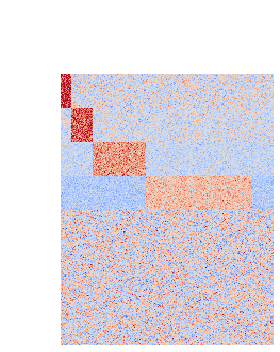

In [11]:
scenario = "A_"+str(n_biomarkers)
print(scenario)
exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),
                                                         g_size=n_biomarkers,
                                                         frac_samples=frac_samples,
                                                         m=m,std=std,
                                                         #outdir = False,outfile_basename=False, 
                                                         g_overlap=False,s_overlap=False,
                                                         seed = seed, 
                                                         #add_coexpressed = add_coexpressed
                                                        )




############ Plots ##################
plot_heatmap(exprs = exprs, 
            ground_truth = ground_truth, 
            coexpressed_modules = coexpressed_modules, 
            fig_file = "" #"img/Fig3A.png" 
            )

In [12]:
# save expression to a file
exprs_file = "../test_data/"+scenario+".exprs.tsv.gz"
exprs.to_csv(exprs_file,sep = "\t")

# format ground truth table as bicluster table and save
biclusters_file_name = "../test_data/"+scenario+".true_biclusters.tsv"
true_biclusters = save_ground_truth_as_bicluster(ground_truth,biclusters_file_name)
print(biclusters_file_name)
true_biclusters

../test_data/A_500.true_biclusters.tsv


,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,frac
id,,,,,,,,,
bic_0.05,NaN,500,10,"{g_1236, g_1562, g_5059, g_7926, g_8779, g_613...","{s_171, s_143, s_159, s_57, s_66, s_82, s_17, ...",UP,"{g_1236, g_1562, g_5059, g_7926, g_8779, g_613...",{},0.05
bic_0.1,NaN,500,20,"{g_1327, g_6873, g_3462, g_6272, g_7990, g_891...","{s_113, s_0, s_26, s_9, s_67, s_11, s_150, s_7...",UP,"{g_1327, g_6873, g_3462, g_6272, g_7990, g_891...",{},0.1
bic_0.25,NaN,500,50,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...","{s_185, s_196, s_108, s_41, s_85, s_101, s_78,...",UP,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...",{},0.25
bic_0.5,NaN,500,100,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{s_107, s_117, s_139, s_195, s_138, s_81, s_19...",UP,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...",{},0.5


In [13]:
from unpast.run_unpast import unpast
print(exprs_file)
basename = scenario+".predicted"
out_dir = "../test_data/unpast_results/"

pred_biclusters = unpast(exprs_file,
                basename,
                out_dir=out_dir,
                clust_method="Louvain",
                save=True,load=False,
                seed = seed,
                verbose = False)
pred_biclusters

../test_data/A_500.exprs.tsv.gz


,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,40.292961,497,100,"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{s_41, s_143, s_17, s_40, s_115, s_198, s_3, s...",DOWN,{},"{g_6262, g_9748, g_7728, g_4406, g_2407, g_770...","{8194, 2051, 8200, 11, 4108, 2062, 29, 4125, 4...","{0, 2, 3, 5, 6, 9, 11, 13, 14, 17, 20, 24, 25,..."
1,37.646654,496,50,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...","{s_41, s_185, s_196, s_85, s_95, s_101, s_78, ...",UP,"{g_7485, g_3432, g_892, g_5769, g_8572, g_378,...",{},"{6158, 2065, 2073, 6169, 6172, 8229, 6181, 414...","{128, 129, 2, 132, 6, 137, 141, 14, 142, 144, ..."
2,26.021577,158,20,"{g_8255, g_6873, g_7443, g_1150, g_5266, g_627...","{s_113, s_0, s_26, s_9, s_67, s_11, s_150, s_7...",UP,"{g_8255, g_6873, g_7443, g_1150, g_5266, g_627...",{},"{4609, 6657, 7172, 8709, 5126, 3086, 3601, 872...","{0, 130, 5, 9, 11, 150, 26, 161, 168, 170, 49,..."
3,3.159845,2,10,"{g_5468, g_9796}","{s_171, s_143, s_159, s_57, s_66, s_82, s_17, ...",UP,"{g_5468, g_9796}",{},"{5468, 9796}","{66, 165, 134, 171, 143, 17, 82, 87, 57, 159}"
4,1.90042,4,100,"{g_3715, g_4681, g_1820, g_9614}","{s_107, s_117, s_139, s_195, s_81, s_138, s_19...",BOTH,"{g_3715, g_4681, g_9614}",{g_1820},"{4681, 3715, 1820, 9614}","{1, 4, 7, 8, 10, 12, 15, 16, 18, 19, 21, 22, 2..."
5,1.506249,2,98,"{g_3732, g_8355}","{s_41, s_107, s_143, s_117, s_40, s_115, s_198...",BOTH,{g_3732},{g_8355},"{8355, 3732}","{1, 6, 7, 9, 12, 14, 16, 19, 20, 22, 25, 27, 2..."
6,1.325644,2,96,"{g_3207, g_8364}","{s_81, s_193, s_172, s_62, s_52, s_29, s_118, ...",BOTH,{g_8364},{g_3207},"{8364, 3207}","{0, 5, 7, 8, 10, 12, 13, 14, 15, 16, 18, 24, 2..."


### Performance measures 

* Feature and sample set evaluation:
    * wARIs - sum of sample ARIs of all matched biclusters weighted by their prevalence
    * F1_f_avg, F1_s_avg -  F1 for features/samples of best matching biclusters, averaged across four biclusters
    
* For all biclusters:
    * FDR_bics  - FDR = FP/(TP+FP) - fraction of wrongly biclustered elements in among all predicted biclusters  
    * Recall_bics - Recall = TP/P - fractoion of correctly biclustered elements in among all true bicluster

In [14]:
from unpast.utils.eval import calculate_perfromance

all_samples = set(exprs.columns.values) # all samples in the dataset
known_groups = true_biclusters.loc[:,["samples"]].to_dict()["samples"]
known_groups = {"true_biclusters":known_groups} # can be more than one classification => it is a dict of dicts

performances, best_matches = calculate_perfromance(pred_biclusters,
                                                   known_groups,
                                                   all_samples,
                                                   performance_measure="ARI")
# sum of per-bicluster ARIs, weighted proporionally to the bicluster frequency
wARIs = performances["true_biclusters"]
wARIs

1.0

In [15]:
def add_performance_cols(df, target = "genes",all_samples = all_samples):
    best_matches = df.loc[:,:].copy()
    best_matches["pred_"+target] = best_matches["bm_id"].apply(lambda x: pred_biclusters.loc[x,target])
    if target == "samples":
        best_matches.loc[best_matches["is_enriched"]==False,"pred_"+target] = best_matches.loc[best_matches["is_enriched"]==False,"pred_"+target].apply(lambda x: all_samples.difference(x))
    best_matches["bic_id"] = best_matches.index
    best_matches["true_"+target] = best_matches["bic_id"].apply(lambda x: true_biclusters.loc[x,target])
    best_matches["TP_"+target] = best_matches.apply(lambda row: row["true_"+target].intersection(row["pred_"+target]),axis=1)
    # true positive rate == Recall
    best_matches["TPR_"+target] = best_matches.apply(lambda row: len(row["TP_"+target])/len(row["true_"+target]),axis=1)
    # precision
    best_matches["Prec_"+target] = best_matches.apply(lambda row: len(row["TP_"+target])/len(row["pred_"+target]),axis=1)
    best_matches["F1_"+target] = 0
    matched_bic_ids = best_matches["Prec_"+target]+best_matches["TPR_"+target]>0
    best_matches.loc[matched_bic_ids,"F1_"+target] = best_matches.loc[matched_bic_ids,:].apply(lambda row: 2*row["Prec_"+target]*row["TPR_"+target]/(row["Prec_"+target]+row["TPR_"+target]), axis=1 )
    return best_matches


def calc_performance_measures(best_matches_,true_biclusters,pred_biclusters,exprs):
    best_matches = add_performance_cols(best_matches_,target = "samples",all_samples = set(exprs.columns.values))
    best_matches = add_performance_cols(best_matches,target = "genes")
    
    F1_f_avg = best_matches["F1_genes"].sum()/true_biclusters.shape[0]
    F1_s_avg = best_matches["F1_samples"].sum()/true_biclusters.shape[0]
    
    # FP in matched biclusters
    # number of elements in matched biclusters not in true biclusters
    df = best_matches
    pred_P_matched = df["pred_genes"].apply(len)*df["pred_samples"].apply(len)
    TP = df["TP_genes"].apply(len)*df["TP_samples"].apply(len)
    FP1 = pred_P_matched-TP

    #  number of elements in non-matched biclusters
    bm_ids = list(set(best_matches["bm_id"].values))
    not_matched_bic_ids = [x for x in pred_biclusters.index if not x in bm_ids]
    df2 = pred_biclusters.loc[not_matched_bic_ids,:]
    FP2 = df2["n_genes"]*df2["n_samples"]

    FP = FP2.sum()+FP1.sum()
    
    # ratio of predicted bicluster elements (FP) not matching true biclusters, to all biclusters predicted elements (TP+FP)
    P = true_biclusters["n_genes"]* true_biclusters["n_samples"]
    P = P.sum()
    # FDR
    FDR_bic = FP/(TP.sum()+FP)
    
    # Recall
    Recall_bic = TP.sum()/P
    
    return best_matches, F1_f_avg, F1_s_avg,  FDR_bic, Recall_bic


In [16]:
best_matches, F1_f_avg, F1_s_avg,  FDR_bic, Recall_bic =  calc_performance_measures(best_matches,true_biclusters,pred_biclusters,exprs)
wARIs, F1_f_avg, F1_s_avg,  FDR_bic, Recall_bic 

(1.0, 0.6202965493114982, 1.0, 0.010042310241117397, 0.8631111111111112)

### Evaluate all pre-computed biclusters 

In [17]:
from unpast.utils.io import read_bic_table
import pandas as pd
from unpast.utils.eval import calculate_perfromance

out_dir = "../test_data/unpast_results/"
suffix = ".bin=kmeans,pval=0.01,clust=Louvain,direction=DOWN-UP,m=0.33.biclusters.tsv"
suffix = ".seed="+str(42) + suffix 

In [18]:
# calculate performance for all scenarios
performances = {}
for n_biomarkers in [500,5]:
    for s in ["A","C"]:
        scenario = s+"_"+str(n_biomarkers)
        # save expression to a file
        exprs_file = "../test_data/"+scenario+".exprs.tsv.gz"
        exprs = pd.read_csv(exprs_file, sep = "\t", index_col = 0)

        # read true biclusters 
        biclusters_file_name = "../test_data/"+scenario+".true_biclusters.tsv"
        true_biclusters = read_bic_table(biclusters_file_name)
        
        # read predicted biclusters 
        basename = scenario+".predicted"
        pred_biclusters = read_bic_table(out_dir+basename+suffix)
        
        print(scenario, "found biclusters: %s"%pred_biclusters.shape[0])
        
        # Finding best matches and estimating performance 
        all_samples = set(exprs.columns.values) # all samples in the dataset
        known_groups = true_biclusters.loc[:,["samples"]].to_dict()["samples"]
        known_groups = {"true_biclusters":known_groups} # can be more than one classification => it is a dict of dicts

        res, best_matches = calculate_perfromance(pred_biclusters,
                                                           known_groups,
                                                           all_samples,
                                                           performance_measure="ARI")
        # sum of per-bicluster ARIs, weighted proporionally to the bicluster frequency
        wARIs = res["true_biclusters"]
        best_matches, F1_f_avg, F1_s_avg,  FDR_bic, Recall_bic =  calc_performance_measures(best_matches.dropna(),true_biclusters,pred_biclusters,exprs)
        performances[scenario] = {"wARIs":wARIs,
                                  "F1_f_avg":F1_f_avg, 
                                  "F1_s_avg":F1_s_avg, 
                                  "FDR_bic":FDR_bic,
                                  "Recall_bic":Recall_bic
                                 }
performances = pd.DataFrame.from_dict(performances).T
performances

A_500 found biclusters: 7
C_500 found biclusters: 11
A_5 found biclusters: 9
C_5 found biclusters: 19


,wARIs,F1_f_avg,F1_s_avg,FDR_bic,Recall_bic
A_500,1.000000,0.620297,1.000000,0.010042,0.863111
C_500,0.944444,0.514914,0.750000,0.028590,0.740333
A_5,0.838087,0.500000,0.628788,0.790034,0.833333
C_5,0.822222,0.500000,0.498744,0.870345,0.827778
